# GlobAlbedo and associated algorithms

P. Lewis and M. van Leeuwen, UCL/NCEO

This first notebook deals with downloading the data from the database and constructing suitable data structures.

The various forms of (netcdf) inputs are read and the data organised as a set of arrays in set of dictionaries.

These dictionaries are then 'pickled' (saved to disk) for direct use in further processing.

In [2]:
from defaults import *
%matplotlib inline
db = 'http://gws-access.cems.rl.ac.uk/public/globalbedo/.stackXY2/'

data directory /Users/plewis/QA4ECV_ATBD/data


In [24]:
'''
Contact the server for a listing and 
if doit is True download the files and pack into
the dictionary ncfiles. 

Actually, all we really need (to access pre-stored pickle files)
is to set the variable  `datakeys`
'''

doit = True
# set True if you want to download as well
ncfiles = obtain_data(db,doit=doit)
datakeys = ncfiles.keys()
if None:
    # this is most of them
    
#        'prior.v1.nosnow', 'prior.v1.snow1', 'prior.v1.snow2',\

print np.sort(datakeys)

connecting to http://gws-access.cems.rl.ac.uk/public/globalbedo/.stackXY2/
got urls
prior.v1.nosnow/
. . . . . . . . . . . . . . . . . . . . prior.v1.snow2/
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ga.brdf.snow/
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . bbdr.vgt/
. . . . . . . . . . . . . . . . . . . . . . . . . . . prior.v2.snownosnow/
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . bbdr.flags/
prior.v2.snow/
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ga.brdf.merge/
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . bbdr.meris/
. . . . . . . . . . . . . . . . . . . . . . . . . . . mod09/
. . . . . . . . . . . . . . . . . . . . . .

In [25]:
# actually, we only want these particular datasets
datakeys = np.array(['bbdr.flags', 'bbdr.meris', 'bbdr.vgt', 'ga.brdf.merge',\
       'ga.brdf.nosnow', 'ga.brdf.snow', 'mod09', 'myd09',\
       'prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow'])

print np.sort(datakeys)

['bbdr.flags' 'bbdr.meris' 'bbdr.vgt' 'ga.brdf.merge' 'ga.brdf.nosnow'
 'ga.brdf.snow' 'mod09' 'myd09' 'prior.v2.nosnow' 'prior.v2.snow'
 'prior.v2.snownosnow']


In [27]:
'''
Form the data dictionary (in ncdata), reading and storing each of the
datasets in datakeys.

The only complexities in the code are to do with correcting some variants
(e.g. 'MEAN__BAND________' -> 'MEAN_BAND')

The default parsing splits the key on _1_:

thiskey = kk.split('_1_')[0]

A set of 'special' keys are defined that need to be split / interpreted differently
These are specified in the dictionary specials, with the key name and an integer specifying
how many terms to include.

To decode the TIME field, we look at the keys for
'Cov_NIR_f0_NIR_f0','VAR_NIR_f0_NIR_f0','BB_NIR','MODIS_Grid_1km_2D_Data_Fields_Range'
any one of which can lead to the time field.

'''

ncdata = {}

# the integer specifies how many _ fields to include
# eg var/covar are functions of band and kernel so 4 variables, so 5
specials = {
    'Data_Mask_':2,
    'Cov_':5,
    'Mean_':2,
    'VAR_':5,
    'mean_':3,
    'BB_':2,
    'sig_BB_':4,
    'Kgeo_BRDF':3,
    'Kvol_BRDF':3,
    'Kiso_BRDF':3
}

for k in datakeys:
    k =  k.strip('/')
    ncdata[k] = {}
    print k
    try:
        ncdata[k] = load_obj(k)
    except:
        for i in xrange(len(ncfiles[k])):
            ncfile = Dataset('./' +k+'/'+ncfiles[k][i],'r')         
            for kk in np.sort(ncfile.variables.keys()):
                # different data keys in different prior versions    
                # Fix MEAN__BAND________
                for terms in ['MEAN__BAND________']:
                    thiskey = kk
                    if thiskey[:len(terms)] == terms:
                        thiskey = 'MEAN_BAND_'+thiskey.split(terms)[1:]
                        # eg 0_PARAMETER_F0_0000001_000000
                        
                # default
                thiskey = kk.split('_1_')[0]
                
                # check if its in the specials
                for terms in specials.keys():
                    if thiskey[:len(terms)] == terms:
                        thiskey = '_'.join(kk.split('_')[:specials[terms]])

                # time - specific examples for hooks into time field
                for terms in ['Cov_NIR_f0_NIR_f0','VAR_NIR_f0_NIR_f0','BB_NIR',\
                             'MODIS_Grid_1km_2D_Data_Fields_Range']:
                    if thiskey[:len(terms)] == terms:
                        doy = int(kk.split('_')[-2])
                        if ('doy' not in ncdata[k]):
                            print 'TIME'
                            ncdata[k]['doy'] = []
                        ncdata[k]['doy'].append(doy)
                    
                # other quite special ones, but all of a pattern
                # e.g. Snow_Fraction_XXX -> Snow_Fraction
                for terms in ['Snow_Fraction','Goodness_of_Fit','cloud_classif_flags','aot_flags',\
                             'snow_mask','RAA','SZA','VZA']:
                    # prior
                    nn = terms.count('_') + 1
                    if thiskey[:len(terms)] == terms:
                        thiskey = '_'.join(kk.split('_')[:nn]) 

                        
                # ignore these ones
                dontdoit = False
                for terms in ['Weighted_Number_of_Samples', 'Entropy', 'lat', 'lon',\
                             'Goodness_of_Fit','Relative_Entropy','Time_to_the_Closest_Sample',\
                             'AOD550','DEM','NDVI','SM','sig_AOD550','sig_NDVI',\
                             'Proportion_NSamples','l1_flags',\
                              'MODIS_Grid_1km_2D_Data_Fields_num_observations_1km',\
                             'MODIS_Grid_500m_2D_Data_Fields_num_observations_500m']:
                    nn = terms.count('_') + 1
                    if thiskey[:len(terms)] == terms:
                        dontdoit = True
                        thiskey = '_'.join(kk.split('_')[:nn]) 

                if not dontdoit:
                    if (thiskey not in ncdata[k]):
                        print k,thiskey,";",
                        ncdata[k][thiskey] = []
                    # read the data
                    thisdata = ncfile.variables[kk][:]
                    ncdata[k][thiskey].append(thisdata)
            del ncfile
        save_obj(ncdata[k],k)
        


bbdr.flags
bbdr.meris
bbdr.vgt
ga.brdf.merge
TIME
ga.brdf.merge VAR_NIR_f0_NIR_f0 ; ga.brdf.merge VAR_NIR_f0_NIR_f1 ; ga.brdf.merge VAR_NIR_f0_NIR_f2 ; ga.brdf.merge VAR_NIR_f0_SW_f0 ; ga.brdf.merge VAR_NIR_f0_SW_f1 ; ga.brdf.merge VAR_NIR_f0_SW_f2 ; ga.brdf.merge VAR_NIR_f1_NIR_f1 ; ga.brdf.merge VAR_NIR_f1_NIR_f2 ; ga.brdf.merge VAR_NIR_f1_SW_f0 ; ga.brdf.merge VAR_NIR_f1_SW_f1 ; ga.brdf.merge VAR_NIR_f1_SW_f2 ; ga.brdf.merge VAR_NIR_f2_NIR_f2 ; ga.brdf.merge VAR_NIR_f2_SW_f0 ; ga.brdf.merge VAR_NIR_f2_SW_f1 ; ga.brdf.merge VAR_NIR_f2_SW_f2 ; ga.brdf.merge VAR_SW_f0_SW_f0 ; ga.brdf.merge VAR_SW_f0_SW_f1 ; ga.brdf.merge VAR_SW_f0_SW_f2 ; ga.brdf.merge VAR_SW_f1_SW_f1 ; ga.brdf.merge VAR_SW_f1_SW_f2 ; ga.brdf.merge VAR_SW_f2_SW_f2 ; ga.brdf.merge VAR_VIS_f0_NIR_f0 ; ga.brdf.merge VAR_VIS_f0_NIR_f1 ; ga.brdf.merge VAR_VIS_f0_NIR_f2 ; ga.brdf.merge VAR_VIS_f0_SW_f0 ; ga.brdf.merge VAR_VIS_f0_SW_f1 ; ga.brdf.merge VAR_VIS_f0_SW_f2 ; ga.brdf.merge VAR_VIS_f0_VIS_f0 ; ga.brdf.merge VAR_VIS_

In [29]:
# sort doys
for k in datakeys:
    print k,
    # prior has doy only
    if k[:5] != 'prior' and ('doy' in ncdata[k].keys()):
        print '\tdate'
        ncdata[k]['date'] = np.atleast_1d(np.zeros(0))
        ncdata[k]['yeardoy'] = np.array([ [int(str(i)[:4]),int(str(i)[4:])] for i in ncdata[k]['doy']])
        for year,doy in ncdata[k]['yeardoy']:
            ncdata[k]['date'] = np.append(ncdata[k]['date'],\
                                          datetime.date(year, 1, 1) + datetime.timedelta(days=doy))
    else:
        print 

bbdr.flags
bbdr.meris 	date
bbdr.vgt 	date
ga.brdf.merge 	date
ga.brdf.nosnow 	date
ga.brdf.snow 	date
mod09 	date
myd09 	date
prior.v2.nosnow
prior.v2.snow
prior.v2.snownosnow


## Modis QA mask



In [31]:
# The following keys are available for the MODIS datasets

print ncdata['mod09'].keys()

[u'MODIS_Grid_1km_2D_Data_Fields_SensorZenith', u'MODIS_Grid_500m_2D_Data_Fields_q_scan', u'MODIS_Grid_1km_2D_Data_Fields_SensorAzimuth', 'yeardoy', u'MODIS_Grid_1km_2D_Data_Fields_SolarAzimuth', u'MODIS_Grid_500m_2D_Data_Fields_obscov_500m', u'MODIS_Grid_500m_2D_Data_Fields_iobs_res', u'MODIS_Grid_1km_2D_Data_Fields_SolarZenith', u'MODIS_Grid_1km_2D_Data_Fields_Range', u'MODIS_Grid_1km_2D_Data_Fields_orbit_pnt', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b07', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b06', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b05', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b04', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b03', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b02', u'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b01', u'MODIS_Grid_1km_2D_Data_Fields_state_1km', u'MODIS_Grid_1km_2D_Data_Fields_granule_pnt', 'date', u'MODIS_Grid_1km_2D_Data_Fields_gflags', 'doy', u'MODIS_Grid_500m_2D_Data_Fields_QC_500m']


The MODIS QA mask for this product is specified on the [USGS site](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09a1).

Here, we will decode `MODIS_Grid_1km_2D_Data_Fields_state_1km`:

In [134]:
qa = ncdata['mod09']['MODIS_Grid_500m_2D_Data_Fields_QC_500m']
qa2 = ncdata['mod09']['MODIS_Grid_1km_2D_Data_Fields_state_1km']
r = ncdata['mod09']['MODIS_Grid_500m_2D_Data_Fields_sur_refl_b01']

# print some info and examples
qa_ = np.array(qa).astype(np.uint32).flatten()
qa2_ = np.array(qa2).astype(np.uint16).flatten()
r_ = np.array(r).astype(np.int16).flatten() * 0.0001

names = ['MODIS_Grid_500m_2D_Data_Fields_QC_500m','MODIS_Grid_1km_2D_Data_Fields_state_1km',\
         'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b01']

for i,v in enumerate([qa,qa2,r]):
    print names[i],type(v),type(v[0]),v[0].dtype,
    for i in xrange(10):
        print v[i][0][0],
    print

for i,v in enumerate([qa_,qa2_,r_]):
    print names[i],type(v),type(v[0]),v[0].dtype,
    for i in xrange(10):
        print v[i],
    print 
    
# The fill value is 4294967295
# so lets see how many of these we have
'''
for i in np.sort(np.array(np.unique(qa2_)).astype(int)):
    print 'There are',(qa2_ == i).sum(),'values with value %d'%i,bin(i)
    print r_[qa2_ == i]
    print '========================'
'''
    
    
# 136?
qcstr = '8 72 136 200 1032 1288 2056 2120 2184 2248'

qcstr = ''
# lets look at the 2 bits that tell us clear
bitmask = 2**6-1
for i in np.sort(np.unique(qa2_).astype(np.uint16)):
    m = i & bitmask
    if m == 0b001000:
        #print i,'clear',i & bitmask,bin(bitmask),bin(i&bitmask)
        qcstr += ' ' + str(i)
    elif m == 10:
        pass
        #print i,'mixed',i & bitmask,bin(bitmask),bin(i&bitmask)
    else:
        pass
        #print i,'other',i & bitmask,bin(bitmask),bin(i&bitmask)

print 'valid:',qcstr
# Mixed : 
#

for i in np.sort(np.array(qcstr.split()).astype(np.uint16)):
    print 'There are',(qa2_ == i).sum(),'values with value %d'%i,bin(i)
    print r_[qa2_ == i]
    print '========================'

MODIS_Grid_500m_2D_Data_Fields_QC_500m <type 'list'> <type 'numpy.ndarray'> int32 1002159035 1107296257 1073741824 1610612736 1073741824 1073741824 1073741824 1073741824 1073741824 1073741824
MODIS_Grid_1km_2D_Data_Fields_state_1km <type 'list'> <type 'numpy.ndarray'> int16 136 1033 1802 72 1033 1801 1033 1033 1033 1033
MODIS_Grid_500m_2D_Data_Fields_sur_refl_b01 <type 'list'> <type 'numpy.ndarray'> int16 -28672 7007 1064 357 3696 2067 8020 5498 7826 2908
MODIS_Grid_500m_2D_Data_Fields_QC_500m <type 'numpy.ndarray'> <type 'numpy.uint32'> uint32 1002159035 1107296257 1073741824 1610612736 1073741824 1073741824 1073741824 1073741824 1073741824 1073741824
MODIS_Grid_1km_2D_Data_Fields_state_1km <type 'numpy.ndarray'> <type 'numpy.uint16'> uint16 136 1033 1802 72 1033 1801 1033 1033 1033 1033
MODIS_Grid_500m_2D_Data_Fields_sur_refl_b01 <type 'numpy.ndarray'> <type 'numpy.float64'> float64 -2.8672 0.7007 0.1064 0.0357 0.3696 0.2067 0.802 0.5498 0.7826 0.2908
valid:  8 72 136 200 1032 1288 1

In [170]:
def good_qa(t,good4=[0b001000],bitmask=2**6-1):
    bitmask = 2**6-1
    t = np.uint16(t)
    m = t & bitmask
    if m == 0b001000:
        return True
    
def snow_qa(tt):
    # bit 12 MOD35 snow/ice flag
    # bit 15 internal snow algorithm flag
    tt = np.uint16(np.array(tt))
    s1 = (tt & 2**12)>>12
    s2 = (tt & 2**15)>>15
    snow = np.logical_or(s1,s2)
    return snow

def modis_qa(tt,good4=[0b001000],bitmask=2**6-1):
    # work on array
    tt = np.uint16(np.array(tt))
    return (tt & bitmask) == good4[0]


tt = np.sort(np.array(qcstr.split()).astype(np.uint16))

print 'snow        ',snow_qa(tt)
print 'good        ',modis_qa(tt)
print 'good no snow',np.logical_and(modis_qa(tt),~snow_qa(tt))
print 'good snow   ',np.logical_and(modis_qa(tt),snow_qa(tt))


snow         [False False False False False False False False  True  True  True  True
 False False False False  True  True  True  True]
good         [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
good no snow [ True  True  True  True  True  True  True  True False False False False
  True  True  True  True False False False False]
good snow    [False False False False False False False False  True  True  True  True
 False False False False  True  True  True  True]


## narrow to broadband conversion

We use linear equatiuons of the form:

$$
B = w^T b
$$

where vector $B$ has 3 broad wavebands, $b$ is a vector of the 7 MODIS bands, and $w$ is the weighting matrix.

We also have an uncertainty matrix for the MODIS observations, following Roy et al. (2005) RSE 97: 137-162.

We use the narrow to broadband coefficients of [Liang, 2000](https://www.google.co.uk/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwiOzKrEvYzLAhVBURoKHd7ECxIQFggiMAA&url=http%3A%2F%2Fterpconnect.umd.edu%2F~sliang%2Fpapers%2FRSE.N2B.1.pdf&usg=AFQjCNFDnawdSlcNvMTkNTSdSr447wfbnA&sig2=7SFNU8MS65X9aaVBtv30ow)

In [141]:
# compute modis weights from Roy et al. (2005) RSE 97: 137-162
modissd = np.array([0.004, 0.015, 0.003, 0.004, 0.013, 0.010, 0.006])

RI = np.matrix(np.diag(modissd*modissd)).I

bands = ['VIS','NIR','SW']

# modis narrow to broadband coefficients from Liang, 2000
BBweights = np.array([[0.331,0.000, 0.424,0.246,0.000,0.000,0.000, 0.0000],\
                      [0.039,0.504,-0.071,0.105,0.252,0.069,0.101, 0.0000],\
                      [0.160,0.291, 0.243,0.116,0.112,0.000,0.081,-0.0015]])

# renormalise
#BBweights = (BBweights.T / BBweights.sum(axis=1)).T

In [142]:
# form the subset of the weights matrix
H = np.matrix(BBweights[:,:-1]).T

# then the uncertainty (4x4 matrix) is
BBuncertainty_weight = (H.T * RI * H)

In [184]:
# sort MODIS data
for k in ncdata.keys():
    # MODIS processing
    #
    # reflectance observations
    monkey = 'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b%02d'
    monkey1 = monkey%1
    if monkey1 in ncdata[k].keys():
        print k

        modiswt = 1./(modissd*modissd)
        print '\tobs:',k,len(ncdata[k][monkey1])
        ncdata[k]['reflectance'] = np.zeros((7,len(ncdata[k][monkey1])))
        ncdata[k]['weight'] = np.zeros((7,len(ncdata[k][monkey1])))
        for i in xrange(1,8):
            ncdata[k]['reflectance'][i-1,:] = np.array(ncdata[k][monkey%i]).squeeze().astype(float) * 0.0001
            ncdata[k]['weight'][i-1,:] = modiswt[i-1]

            # apply the linear model to the mean
            BBrefl = (np.dot(BBweights[:,:-1],ncdata[k]['reflectance']).T + BBweights[:,-1]).T
            # narrow to broadband
            ncdata[k]['BB_VIS'] = BBrefl[0]
            ncdata[k]['BB_NIR'] = BBrefl[1]
            ncdata[k]['BB_SW']  = BBrefl[2]
            
            # uncertainty
            #BBweight = np.dot(BBweights[:,:-1],ncdata[k]['weight'])
            for b1,band1 in enumerate(['VIS','NIR','SW']):
                for b2,band2 in enumerate(['VIS','NIR','SW']):
                    if b2 <= b1:
                        term = 'weight_BB_%s_%s'%(band1,band2)
                        ncdata[k][term] = BBuncertainty_weight[b1,b2]

                        
            '''
            'snow        ',snow_qa(tt)
            'good        ',modis_qa(tt)
            'good no snow',np.logical_and(modis_qa(tt),~snow_qa(tt))
            'good snow   ',np.logical_and(modis_qa(tt),snow_qa(tt))
            '''
            # extract qa
            #test = np.array(ncdata[k]['MODIS_Grid_500m_2D_Data_Fields_QC_500m']).squeeze()
            tt = np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_state_1km']).squeeze()
            ncdata[k]['mask'] = modis_qa(tt)
            ncdata[k]['mask_snow'] = np.logical_and(modis_qa(tt),snow_qa(tt))
            ncdata[k]['mask_nosnow'] = np.logical_and(modis_qa(tt),~snow_qa(tt))
            # obscov - use as a weighting term?
            ncdata[k]['obscov'] = 0.01*np.array(ncdata['mod09']['MODIS_Grid_500m_2D_Data_Fields_obscov_500m']).squeeze().astype(float)

            # angles
            vza = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SensorZenith']).squeeze().astype(float)
            sza = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SolarZenith']).squeeze().astype(float)
            vaa = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SensorAzimuth']).squeeze().astype(float)
            saa = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SolarAzimuth']).squeeze().astype(float)
            kern = kernels.Kernels(vza, sza, vaa-saa, doIntegrals=False, RossHS=False, RossType='Thick',\
                     LiType='Sparse', normalise=1, nbar=0., RecipFlag=True, MODISSPARSE=True)

            ncdata[k]['Kvol'],ncdata[k]['Kgeo'] = np.asarray(kern.Ross),np.asarray(kern.Li)



mod09
	obs: mod09 5727
myd09
	obs: myd09 4916


## Examine MODIS data

We can now examine the MODIS broad band reflectance data.

We can look in particular at whether the two formulae given by Liang for direct and diffuse effects make any real difference.

We can also examine the quality and quantity of snow and no snow data:

0.00571615965156
0.0177333662389
0.0101877402269
0.00571615965156
0.0177333662389
0.0101877402269
0.00571615965156
0.0177333662389
0.0101877402269
0.00571615965156
0.0177333662389
0.0101877402269


(0, 1.2000000000000002)

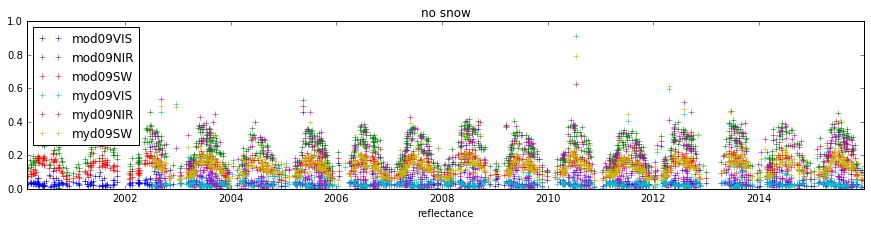

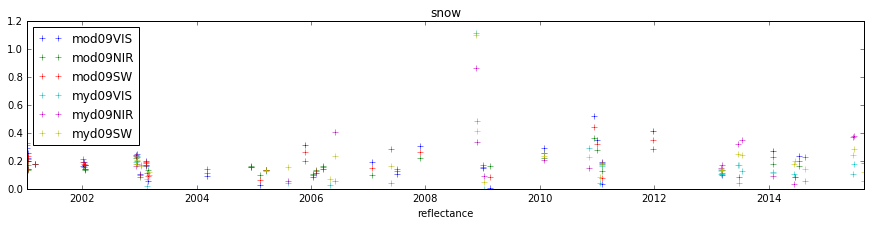

In [186]:
bands = ['VIS','NIR','SW']

plt.figure(figsize=(15,3))
for mod in ['mod09','myd09']:
    for i in xrange(3):
        mm = ncdata[mod]['mask_nosnow']
        x = ncdata[mod]['date'][mm]
        y = ncdata[mod]['BB_%s'%bands[i]][mm]
        w = ncdata[mod]['weight_BB_%s_%s'%(bands[i],bands[i])]
        unc =  np.sqrt(1/w)
        print unc
        plt.plot(x,y,'+',label=mod+bands[i])
plt.xlabel('time')
plt.xlabel('reflectance')
plt.legend(loc='best')
plt.title('no snow')
plt.ylim(0,None)

plt.figure(figsize=(15,3))
for mod in ['mod09','myd09']:
    for i in xrange(3):
        mm = ncdata[mod]['mask_snow']
        x = ncdata[mod]['date'][mm]
        y = ncdata[mod]['BB_%s'%bands[i]][mm]
        w = ncdata[mod]['weight_BB_%s_%s'%(bands[i],bands[i])]
        unc =  np.sqrt(1/w)
        print unc
        plt.plot(x,y,'+',label=mod+bands[i])
plt.xlabel('time')
plt.xlabel('reflectance')
plt.legend(loc='best')
plt.title('snow')
plt.ylim(0,None)

In [190]:
# save objects
for k in datakeys:
    print k
    try:
        save_obj(ncdata[k],k+'_s2.0_')
    except:
        pass

bbdr.flags
bbdr.meris
bbdr.vgt
ga.brdf.merge
ga.brdf.nosnow
ga.brdf.snow
mod09
myd09
prior.v2.nosnow
prior.v2.snow
prior.v2.snownosnow
